[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gomar0801/BachGen/blob/main/notebooks/Pipeline%20complet%20BachGen.ipynb)

In [1]:
%%capture
# Clone the BachGen repository
!rm -rf BachGen && git clone https://github.com/gomar0801/BachGen.git
!chmod +x ./BachGen/scripts/setup.sh
!./BachGen/scripts/setup.sh

In [ ]:
!rm -rf BachGen && git clone https://github.com/gomar0801/BachGen.git

Cloning into 'BachGen'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 414 (delta 135), reused 65 (delta 29), pack-reused 190 (from 1)
Receiving objects: 100% (414/414), 1.02 MiB | 11.01 MiB/s, done.
Resolving deltas: 100% (215/215), done.


In [2]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=73b256fd517d84434eb742e8d0baeecf77e3ab094d1a399309632f99cf58cc16
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [3]:
from bachgen.download_data import download_all
from bachgen.extract import extract_archive
from bachgen.data_filter import load_and_filter_piano_classical
from bachgen.mxl_to_musicxml import convert_mxl_to_musicxml
from bachgen.display_and_play_partition import display_and_play
from bachgen.score_to_tokens_simplify import MusicXML_to_tokens
from bachgen.tokens_to_musicxml import convert_tokens_to_musicxml

# Telechargement des données

In [ ]:
download_all()

⬇️  Téléchargement depuis https://zenodo.org/records/15571083/files/mxl.tar.gz?download=1 ...
✅ Fichier téléchargé : data/mxl.tar.gz
⬇️  Téléchargement depuis https://zenodo.org/records/15571083/files/PDMX.csv?download=1 ...
✅ Fichier téléchargé : data/PDMX.csv


In [ ]:
extract_folder=extract_archive("/content/data/mxl.tar.gz")

📦 Extraction de /content/data/mxl.tar.gz vers data/mxl ...
✅ Extraction terminée dans : data/mxl


# Filtrage

In [ ]:
df_piano_classical = load_and_filter_piano_classical()

🎹 24008 partitions de piano (genre classique) trouvées.


# MXL to MusicXML

In [ ]:
import warnings
from music21 import musicxml
warnings.simplefilter("ignore", musicxml.xmlToM21.MusicXMLWarning)

In [ ]:
import os
from pathlib import Path
from tqdm import tqdm
import concurrent.futures

MXL_ROOT = Path("data/mxl")
OUT_DIR  = Path("data/musicxml_classical_piano_convert")
OUT_DIR.mkdir(parents=True, exist_ok=True)

PATH_COL = "mxl"  # ou "mxl_path" selon ton CSV
TIMEOUT  = 10     # secondes max par fichier

# 1) Nettoyage du dataframe
df_clean = (
    df_piano_classical
    .loc[df_piano_classical[PATH_COL].notna(), [PATH_COL]]
    .copy()
)
df_clean[PATH_COL] = df_clean[PATH_COL].astype(str)
df_clean = df_clean[df_clean[PATH_COL].str.lower().str.endswith(".mxl")]
df_clean = df_clean.drop_duplicates(subset=[PATH_COL])

errors = []
done = 0

# Fonction wrapper pour conversion
def convert_with_timeout(in_path, out_path):
    convert_mxl_to_musicxml(str(in_path), str(out_path))

# Boucle principale
for rel in tqdm(df_clean[PATH_COL].values, total=len(df_clean)):
    in_path = MXL_ROOT / rel

    if not in_path.exists():
        errors.append(("missing", str(in_path)))
        continue

    out_name = in_path.stem + ".musicxml"
    out_path = OUT_DIR / out_name

    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(convert_with_timeout, in_path, out_path)
        try:
            future.result(timeout=TIMEOUT)
            done += 1
        except concurrent.futures.TimeoutError:
            errors.append((str(in_path), f"Timeout > {TIMEOUT}s"))
        except Exception as e:
            errors.append((str(in_path), str(e)))

print(f"✅ Conversion terminée: {done} fichiers créés dans {OUT_DIR}")
if errors:
    print(f"⚠️ {len(errors)} problème(s). Exemples:")
    for e in errors[:10]:
        print("  -", e)


 53%|█████▎    | 12723/24004 [2:27:27<2:10:44,  1.44it/s]


KeyboardInterrupt: 

In [ ]:
!cp -r /content/data/musicxml_classical_piano_convert /content/drive/MyDrive/Stage\ MusicXML/

In [ ]:
from pathlib import Path
import shutil

def pack_musicxml_dir(src="data/musicxml_classical_piano_convert",
                      out_zip="musicxml_classical_piano_convert.zip"):
    src = Path(src)
    assert src.exists() and src.is_dir(), f"Dossier introuvable: {src}"

    # shutil.make_archive ajoute l’extension, donc on lui passe le chemin sans .zip
    out_base = Path(out_zip).with_suffix("")
    archive_path = shutil.make_archive(str(out_base), 'zip', root_dir=str(src), base_dir=".")
    print(f"✅ Archive créée: {archive_path}")

pack_musicxml_dir()

✅ Archive créée: /content/musicxml_classical_piano_convert.zip


# MusicXML to Tokens (+statistics)

## Sans statistique

In [ ]:
from pathlib import Path

SRC_DIR = Path("data/musicxml_classical_piano")  # dossier avec les .musicxml
OUT_DIR = Path("data/tokens_classical_piano")
OUT_DIR.mkdir(parents=True, exist_ok=True)

for xml_file in SRC_DIR.glob("*.musicxml"):
    try:
        tokens = MusicXML_to_tokens(str(xml_file))
        out_file = OUT_DIR / (xml_file.stem + ".txt")
        with open(out_file, "w", encoding="utf-8") as f:
            f.write(" ".join(tokens))
        print(f"✅ {xml_file.name} → {out_file.name}")
    except Exception as e:
        print(f"❌ {xml_file.name} -> {e}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  → Backup : -40320
    • Note: Rest, Voice: 2, Start: 0, Duration: 30240, Chord: False
    • Note: G4, Voice: 2, Start: 30240, Duration: 10080, Chord: False
[Résultat] 10 notes extraites avec positions.


  → 10 notes extraites avec positions
  → Notes triées par position :
    • Pos     0, Voice 1, Note: G4
    • Pos     0, Voice 1, Note: D5
    • Pos     0, Voice 2, Note: Rest
    • Pos 10080, Voice 1, Note: A4
    • Pos 10080, Voice 1, Note: D5
    • Pos 20160, Voice 1, Note: G4
    • Pos 20160, Voice 1, Note: D5
    • Pos 30240, Voice 1, Note: C5
    • Pos 30240, Voice 2, Note: G4
    • Pos 35280, Voice 1, Note: D5

  → Position 0 : 3 élément(s)
    ⚠ Silences superposés détectés, ils sont ignorés.
    ↳ Durée harmonisée de l'accord : 10080

  → Position 10080 : 2 élément(s)
    ↳ Durée harmonisée de l'accord : 10080

  → Position 20160 : 2 élément(s)
    ↳ Durée harmonisée de l'accord : 10080

  → Posit

KeyboardInterrupt: 

## Avec Statistiques

In [8]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/musicxml_classical_piano_convert  /content/data

In [9]:
from pathlib import Path
from io import StringIO
from contextlib import redirect_stdout
import csv

SRC_DIR = Path("/content/data/musicxml_classical_piano_convert")   # your .musicxml folder
TOK_DIR = Path("data/tokens_classical_piano_simplify")
TOK_DIR.mkdir(parents=True, exist_ok=True)

STATS_CSV = Path("data/tokenization_stats_V2.csv")

def tokenize_with_stats(xml_path: Path, note_name=True):
    """
    Runs MusicXML_to_tokens while capturing its debug prints,
    then parses those prints to compute per-piece statistics.
    Returns (tokens, stats_dict).
    """
    buf = StringIO()
    with redirect_stdout(buf):
        tokens = MusicXML_to_tokens(str(xml_path), note_name=note_name)
    log = buf.getvalue().splitlines()

    # --- Parse debug lines ---
    # Anchors based on the messages you already print:
    # - "Note transparente détectée, ignorée"
    # - "Silences superposés détectés, ils sont ignorés."
    # - "↳ Durée harmonisée de l'accord :"
    # - "[note_to_tokens] Traitement d'une note ou d'un groupe"
    # - "  → Rest detected"
    total_notes_seen      = 0   # every time note_to_tokens starts processing a note/rest
    rests_kept            = 0   # rests that reached note_to_tokens and were kept
    rests_ignored_overlap = 0   # rests ignored in rewrite step (overlapped)
    transparent_ignored   = 0   # notes with print-object="no", ignored
    harmonize_events      = 0   # positions where harmonization line was printed

    for line in log:
        if "[note_to_tokens] Traitement d'une note ou d'un groupe" in line or "CHORD_detecté" in line:
            total_notes_seen += 1
        elif "Note transparente détectée, ignorée" in line:
            transparent_ignored += 1
        elif "→ Rest detected" in line:
            rests_kept += 1
        elif "Silences superposés détectés, ils sont ignorés" in line:
            rests_ignored_overlap += 1
        elif "Durée harmonisée de l'accord" in line:
            harmonize_events += 1

    # --- Compute percentages (defensive against /0) ---
    # 1) Transparent notes % over all items that hit note_to_tokens (includes transparents)
    trans_pct = (transparent_ignored / total_notes_seen * 100.0) if total_notes_seen else 0.0

    # 2) Overlapped rests % = ignored rests / (ignored + kept rests)
    total_rests_considered = rests_kept + rests_ignored_overlap
    overlap_rest_pct = (rests_ignored_overlap / total_rests_considered * 100.0) if total_rests_considered else 0.0

    # 3) Harmonized chord duration % = harmonize_events / total accord positions observed in logs.
    #    We approximate denominator with harmonize_events (i.e., report the rate as count per piece),
    #    and still expose the raw count so you can interpret it.
    #    If you later add a line like "→ Position ... : n élément(s)" we could refine this.
    harmonize_rate_pct = None  # unknown denominator; we’ll report the raw count instead

    stats = {
        "file": xml_path.name,
        "total_items_seen": total_notes_seen,
        "transparent_ignored": transparent_ignored,
        "rests_kept": rests_kept,
        "rests_ignored_overlap": rests_ignored_overlap,
        "harmonize_events": harmonize_events,
        "transparent_pct": round(trans_pct, 3),
        "overlap_rest_pct": round(overlap_rest_pct, 3),
        # leave harmonize_rate_pct as None; we’ll put just the count
    }
    return tokens, stats

# ---- Run over all files and save tokens + stats ----
all_stats = []
for xml_file in sorted(SRC_DIR.rglob("*.musicxml")):  # rglob for subfolders; use glob if flat
    try:
        tokens, stats = tokenize_with_stats(xml_file, note_name=True)
        # save tokens
        out_txt = TOK_DIR / (xml_file.stem + ".txt")
        out_txt.write_text(" ".join(tokens), encoding="utf-8")
        all_stats.append(stats)
        print(f"✅ {xml_file.relative_to(SRC_DIR)}  "
              f"[transp {stats['transparent_pct']}% | overl.rest {stats['overlap_rest_pct']}% | "
              f"harmonize_events={stats['harmonize_events']}]")
    except Exception as e:
        print(f"❌ {xml_file} -> {e}")

# write CSV summary
with STATS_CSV.open("w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=[
            "file", "total_items_seen", "transparent_ignored",
            "rests_kept", "rests_ignored_overlap", "harmonize_events",
            "transparent_pct", "overlap_rest_pct"
        ],
    )
    writer.writeheader()
    writer.writerows(all_stats)

print(f"\n📊 Stats écrites dans: {STATS_CSV}")
print(f"🧾 Tokens enregistrés dans: {TOK_DIR}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
✅ QmYWqrym1rdScFw6CQ21CijuSseutGiudRJvsutL4VbPNY.musicxml  [transp 0.0% | overl.rest 69.231% | harmonize_events=38]
✅ QmYWrvqfjZ8oWf7reSCCdW9iwCZrdPQZ4Go6YP1y7wPTJ4.musicxml  [transp 0.0% | overl.rest 100.0% | harmonize_events=65]
✅ QmYWun4B1NopTox1tUcSbaDDnGwzxczQ7uRr9BfXN2j6Hy.musicxml  [transp 1.852% | overl.rest 87.5% | harmonize_events=20]
✅ QmYX2aqk5cHmV7CkJhHVj6P8jEvyykTSGepymXXiuLmfy6.musicxml  [transp 0.0% | overl.rest 0.0% | harmonize_events=71]
✅ QmYX3wgQXBaxVcFX1eRnqXP9oKamToqBGCjkJRFuaeSFed.musicxml  [transp 0.0% | overl.rest 63.636% | harmonize_events=23]
✅ QmYX3xRhGw6Z8G53zLY5LJMkZfdyqHfsMaYK7ftPGmWtw7.musicxml  [transp 0.775% | overl.rest 91.304% | harmonize_events=84]
✅ QmYX445hkG73EMyP5QkjSg2qHFon7CUYTSK2dArSXvxCEn.musicxml  [transp 4.461% | overl.rest 0.0% | harmonize_events=129]
✅ QmYX6tHEXwTVgiRiXroNTuFHZ5A4uZFanFPtEWpwxxhDjm.musicxml  [transp 0.0% | overl.rest 0.0% | harmonize_events=0]


In [10]:
!cp -r /content/data/tokens_classical_piano_simplify /content/drive/MyDrive/Stage\ MusicXML/

In [11]:
!cp -r /content/data/tokenization_stats_V2.csv /content/drive/MyDrive/Stage\ MusicXML/

# Construction dictionaire tokens<->id

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/tokens_classical_piano_convert /content/data/

In [12]:
# bachgen/vocab_utils.py
from __future__ import annotations
import json, os
from pathlib import Path
from typing import Dict, Iterable, List, Tuple, Set

# --- 1) Parcours & construction vocab ---------------------------------------

def iter_token_lines(files: Iterable[Path]) -> Iterable[List[str]]:
    """
    Itère sur les lignes de fichiers .txt contenant des tokens séparés par des espaces.
    Rend une liste de tokens par ligne (sans espaces vides).
    """
    for f in files:
        with open(f, "r", encoding="utf-8") as fh:
            for line in fh:
                line = line.strip()
                if not line:
                    continue
                yield line.split()

def build_vocab(
    token_files: Iterable[Path],
    specials: List[str] = ("[PAD]", "[UNK]", "<BOS>", "<EOS>"),
    min_freq: int = 1,
) -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Construit un vocab {token->id} et {id->token}.
    - specials apparaissent en tête, dans l'ordre donné.
    - min_freq permet de filtrer les tokens trop rares (=> retombent sur [UNK]).

    Retourne (token2id, id2token).
    """
    from collections import Counter
    counts = Counter()
    for toks in iter_token_lines(token_files):
        counts.update(toks)

    # Assure présence des spéciaux
    specials = list(specials)
    if "[UNK]" not in specials:
        specials.append("[UNK]")

    # Démarre l’indexation : spéciaux d’abord
    token2id: Dict[str, int] = {}
    id2token: Dict[int, str] = {}
    next_id = 0

    for sp in specials:
        if sp not in token2id:
            token2id[sp] = next_id
            id2token[next_id] = sp
            next_id += 1

    # Ajoute vocab “normal”, trié (stable) pour reproductibilité
    # tri par fréquence décroissante puis lexicographique
    items = [(tok, freq) for tok, freq in counts.items() if freq >= min_freq and tok not in token2id]
    items.sort(key=lambda x: (-x[1], x[0]))

    for tok, _ in items:
        token2id[tok] = next_id
        id2token[next_id] = tok
        next_id += 1

    return token2id, id2token

# --- 2) Sauvegarde / chargement ---------------------------------------------

def save_vocab(path: Path, token2id: Dict[str, int]) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(token2id, f, ensure_ascii=False, indent=2)

def load_vocab(path: Path) -> Tuple[Dict[str, int], Dict[int, str]]:
    with open(path, "r", encoding="utf-8") as f:
        token2id = json.load(f)
    id2token = {int(i): t for t, i in token2id.items()}
    return token2id, id2token

# --- 3) Encodage / décodage -------------------------------------------------

def encode_tokens(
    tokens: List[str],
    token2id: Dict[str, int],
    add_bos: bool = False,
    add_eos: bool = False,
) -> List[int]:
    """
    Convertit une liste de tokens -> liste d'ids.
    Les inconnus vont sur [UNK].
    """
    unk_id = token2id.get("[UNK]")
    if unk_id is None:
        raise ValueError("Le vocab ne contient pas [UNK].")

    ids: List[int] = []
    if add_bos and "<BOS>" in token2id:
        ids.append(token2id["<BOS>"])

    for t in tokens:
        ids.append(token2id.get(t, unk_id))

    if add_eos and "<EOS>" in token2id:
        ids.append(token2id["<EOS>"])

    return ids

def decode_ids(
    ids: List[int],
    id2token: Dict[int, str],
    drop_specials: Set[str] | None = None,
) -> List[str]:
    """
    Convertit une liste d'ids -> liste de tokens.
    drop_specials permet d’omettre des spéciaux (ex: {"[PAD]", "<BOS>", "<EOS>"}).
    """
    out: List[str] = []
    drop_specials = drop_specials or set()
    for i in ids:
        tok = id2token.get(int(i), "[UNK]")  # robustesse si id inconnu
        if tok in drop_specials:
            continue
        out.append(tok)
    return out

# --- 4) Utilitaires fichiers -------------------------------------------------

def encode_file_to_ids(
    in_path: Path,
    out_path: Path,
    token2id: Dict[str, int],
    add_bos: bool = False,
    add_eos: bool = False,
) -> None:
    """
    Lit un fichier .txt (tokens séparés par espaces, plusieurs lignes),
    écrit un .ids.txt (ids séparés par espaces, une ligne par ligne).
    """
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with open(in_path, "r", encoding="utf-8") as fin, open(out_path, "w", encoding="utf-8") as fout:
        for line in fin:
            toks = line.strip().split()
            if not toks:
                fout.write("\n")
                continue
            ids = encode_tokens(toks, token2id, add_bos=add_bos, add_eos=add_eos)
            fout.write(" ".join(str(i) for i in ids) + "\n")


In [13]:
from pathlib import Path


TOK_DIR = Path("/content/data/tokens_classical_piano_simplify")              # là où sont tes .txt de tokens
IDS_DIR = Path("data/token_ids_simplify")           # là où on mettra les ids
VOCAB_PATH = Path("data/vocab/token2id.json")

# 1) construire le vocab sur tous les fichiers de tokens
token_files = sorted(TOK_DIR.glob("*.txt"))
token2id, id2token = build_vocab(token_files, specials=["[PAD]","[UNK]","<BOS>","<EOS>"])
save_vocab(VOCAB_PATH, token2id)

# 2) recharger plus tard si besoin
token2id, id2token = load_vocab(VOCAB_PATH)

# 3) encoder tous les .txt -> .ids.txt
for tf in token_files:
    out = IDS_DIR / (tf.stem + ".ids.txt")
    encode_file_to_ids(tf, out, token2id, add_bos=True, add_eos=True)

print(f"Vocab taille = {len(token2id)} ; fichiers ids écrits dans {IDS_DIR}")


Vocab taille = 327 ; fichiers ids écrits dans data/token_ids_simplify


In [14]:
print (token2id)

{'[PAD]': 0, '[UNK]': 1, '<BOS>': 2, '<EOS>': 3, 'len_1': 4, 'len_1/2': 5, 'bar': 6, 'note_D4': 7, 'len_1/4': 8, 'note_G4': 9, 'note_C4': 10, 'note_F4': 11, 'note_G3': 12, 'len_2': 13, 'note_A4': 14, 'note_E4': 15, 'note_A3': 16, 'note_Eb4': 17, 'note_Bb3': 18, 'note_C5': 19, 'note_F3': 20, 'rest': 21, 'note_D3': 22, 'note_Bb4': 23, 'note_D5': 24, 'note_C3': 25, 'len_3/2': 26, 'note_B3': 27, 'note_B4': 28, 'note_Eb3': 29, 'note_Ab3': 30, 'note_F#4': 31, 'len_3/4': 32, 'note_Bb2': 33, 'note_E3': 34, 'note_Ab4': 35, 'len_3': 36, 'note_E5': 37, 'note_A2': 38, 'note_C#4': 39, 'note_F#3': 40, 'note_Db4': 41, 'note_G2': 42, 'note_Ab2': 43, 'len_4': 44, 'len_1/3': 45, 'note_C#5': 46, 'note_B2': 47, 'note_Eb5': 48, 'note_F5': 49, 'note_G#4': 50, 'note_Db3': 51, 'note_G5': 52, 'clef_treble': 53, 'note_G#3': 54, 'clef_bass': 55, 'time_4/4': 56, 'note_A5': 57, 'note_F#5': 58, 'L': 59, 'R': 60, 'note_Db5': 61, 'note_D#4': 62, 'note_F2': 63, 'len_1/6': 64, 'note_C#3': 65, 'note_Gb4': 66, 'len_1/8':

In [16]:
!cp -r /content/data/token_ids_simplify /content/drive/MyDrive/Stage\ MusicXML/

In [22]:
!cp -r /content/data/vocab /content/drive/MyDrive/Stage\ MusicXML/

In [19]:
import json

# 📂 Fichiers
VOCAB_FILE = "/content/data/vocab/token2id.json"
FILE_IDS = "/content/data/token_ids_simplify/QmP11jvbDJABdQVPs6W9x2ZrahPV25mqF8MHYfkpGhmc1s.ids.txt"  # exemple

# 📥 Charger le vocabulaire
with open(VOCAB_FILE, "r", encoding="utf-8") as f:
    vocab = json.load(f)

# 🔄 Créer dictionnaire inverse : {id: token}
id_to_token = {str(v): k for k, v in vocab.items()}

# 📥 Lire le fichier d'IDs
with open(FILE_IDS, "r", encoding="utf-8") as f:
    ids = f.read().strip().split()

# 🔄 Convertir en tokens
tokens = [id_to_token[i] for i in ids]

# 📤 Résultat
print(" ".join(tokens))

<BOS> R bar key_flat_3 time_4/4 clef_treble note_G4 note_Eb4 len_3/2 note_Ab4 note_F4 len_1/2 note_Bb4 note_G4 len_1/2 note_G4 note_Eb4 len_1/2 note_F4 note_Eb4 len_1/2 note_Eb4 note_Eb4 len_1/2 bar note_Ab4 note_Eb4 len_1 note_C5 note_Eb4 len_1 note_Bb4 note_Eb4 len_2 bar note_Bb4 note_Eb4 len_3/2 note_C5 note_Eb4 len_1/2 note_Bb4 note_Eb4 len_1/2 note_G4 note_Eb4 len_1/2 note_F4 note_D4 len_1/2 note_Eb4 note_Eb4 len_1/2 bar note_Ab4 note_D4 len_1 note_G4 note_Eb4 len_1 note_F4 note_D4 len_2 bar note_G4 note_Eb4 len_3/2 note_Ab4 note_F4 len_1/2 note_Bb4 note_G4 len_1/2 note_G4 note_Eb4 len_1/2 note_F4 note_D4 len_1/2 note_Eb4 note_Eb4 len_1/2 bar note_Ab4 note_Eb4 len_1 note_C5 note_Ab4 len_1 note_Eb5 note_Ab4 len_2 bar note_Bb4 note_G4 len_3/2 note_C5 note_G4 len_1/2 note_Bb4 note_G4 len_1/2 note_G4 note_Eb4 len_1/2 note_Eb4 note_Eb4 len_1/2 note_F4 note_Eb4 len_1/2 bar note_G4 note_Eb4 len_1 note_F4 note_D4 len_1 note_Eb4 note_Eb4 len_2 bar note_Eb5 note_G4 len_3/2 note_Bb4 note_G4 

In [17]:
import json

def decode_file(file_path, vocab_file, join_tokens=True):
    """
    Décode un fichier contenant des IDs de tokens en texte lisible ou en liste de tokens.

    Args:
        file_path (str): chemin vers le fichier contenant les IDs (séparés par espaces)
        vocab_file (str): chemin vers le fichier vocab.json
        join_tokens (bool): si True, retourne une seule chaîne de texte, sinon une liste de tokens

    Returns:
        str | list: la séquence décodée
    """
    # Charger le vocabulaire
    with open(vocab_file, "r", encoding="utf-8") as f:
        vocab = json.load(f)

    # Créer dictionnaire inverse {id: token}
    id_to_token = {str(v): k for k, v in vocab.items()}

    # Lire les IDs depuis le fichier
    with open(file_path, "r", encoding="utf-8") as f:
        ids = f.read().strip().split()

    # Décoder en tokens
    tokens = [id_to_token[i] for i in ids if i in id_to_token]

    return " ".join(tokens) if join_tokens else tokens


In [20]:
decoded_text = decode_file("/content/data/token_ids_simplify/QmP11jvbDJABdQVPs6W9x2ZrahPV25mqF8MHYfkpGhmc1s.ids.txt", "/content/data/vocab/token2id.json")
print(decoded_text)

decoded_tokens = decode_file("/content/data/token_ids_simplify/QmP11jvbDJABdQVPs6W9x2ZrahPV25mqF8MHYfkpGhmc1s.ids.txt", "/content/data/vocab/token2id.json", join_tokens=False)
print(decoded_tokens[:20])  # Affiche les 20 premiers tokens


<BOS> R bar key_flat_3 time_4/4 clef_treble note_G4 note_Eb4 len_3/2 note_Ab4 note_F4 len_1/2 note_Bb4 note_G4 len_1/2 note_G4 note_Eb4 len_1/2 note_F4 note_Eb4 len_1/2 note_Eb4 note_Eb4 len_1/2 bar note_Ab4 note_Eb4 len_1 note_C5 note_Eb4 len_1 note_Bb4 note_Eb4 len_2 bar note_Bb4 note_Eb4 len_3/2 note_C5 note_Eb4 len_1/2 note_Bb4 note_Eb4 len_1/2 note_G4 note_Eb4 len_1/2 note_F4 note_D4 len_1/2 note_Eb4 note_Eb4 len_1/2 bar note_Ab4 note_D4 len_1 note_G4 note_Eb4 len_1 note_F4 note_D4 len_2 bar note_G4 note_Eb4 len_3/2 note_Ab4 note_F4 len_1/2 note_Bb4 note_G4 len_1/2 note_G4 note_Eb4 len_1/2 note_F4 note_D4 len_1/2 note_Eb4 note_Eb4 len_1/2 bar note_Ab4 note_Eb4 len_1 note_C5 note_Ab4 len_1 note_Eb5 note_Ab4 len_2 bar note_Bb4 note_G4 len_3/2 note_C5 note_G4 len_1/2 note_Bb4 note_G4 len_1/2 note_G4 note_Eb4 len_1/2 note_Eb4 note_Eb4 len_1/2 note_F4 note_Eb4 len_1/2 bar note_G4 note_Eb4 len_1 note_F4 note_D4 len_1 note_Eb4 note_Eb4 len_2 bar note_Eb5 note_G4 len_3/2 note_Bb4 note_G4 

# Training (Model GPT2 from scratch)

In [14]:
import torch
from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import Dataset
import numpy as np
import json
from pathlib import Path
import os

In [23]:
VOCAB_PATH  = Path("/content/data/vocab/token2id.json")
TOK_IDS_DIR = Path("/content/data/token_ids_simplify")
DATA_DIR    = Path("data/pretokenized_splits")

DATA_DIR.mkdir(parents=True, exist_ok=True)


In [24]:
with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    vocab = json.load(f)

VOCAB_SIZE = len(vocab)

def _get_id(*candidates, default):
    for c in candidates:
        if c in vocab:
            return vocab[c]
    return default

PAD_TOKEN_ID = _get_id("<PAD>", "[PAD]", "PAD", default=0)
BOS_TOKEN_ID = _get_id("<BOS>", "<bos>", "BOS", default=1)
EOS_TOKEN_ID = _get_id("<EOS>", "<eos>", "EOS", default=2)

print(f"Vocab size = {VOCAB_SIZE} | PAD={PAD_TOKEN_ID} BOS={BOS_TOKEN_ID} EOS={EOS_TOKEN_ID}")

Vocab size = 327 | PAD=0 BOS=2 EOS=3


In [26]:
import random

def read_ids_file(path: Path) -> List[int]:
    txt = path.read_text(encoding="utf-8").strip()
    if not txt:
        return []
    return [int(x) for x in txt.split()]

all_sequences = []
for p in sorted(TOK_IDS_DIR.glob("*.txt")):
    ids = read_ids_file(p)
    if len(ids) == 0:
        continue
    # Optionnel: check BOS/EOS
    if ids[0] != BOS_TOKEN_ID or ids[-1] != EOS_TOKEN_ID:
        # On n'échoue pas, mais on prévient.
        pass
    all_sequences.append(ids)

print(f"Trouvé {len(all_sequences)} morceaux dans {TOK_IDS_DIR}")

# Shuffle + split
random.seed(42)
random.shuffle(all_sequences)

n = len(all_sequences)
n_train = int(0.90 * n)
n_valid = int(0.05 * n)
n_test  = n - n_train - n_valid

train_sequences = all_sequences[:n_train]
valid_sequences = all_sequences[n_train:n_train+n_valid]
test_sequences  = all_sequences[n_train+n_valid:]

def save_split(seqs, path: Path):
    with path.open("w", encoding="utf-8") as f:
        for ids in seqs:
            f.write(" ".join(map(str, ids)) + "\n")

save_split(train_sequences, DATA_DIR / "train_ids.txt")
save_split(valid_sequences, DATA_DIR / "valid_ids.txt")
save_split(test_sequences,  DATA_DIR / "test_ids.txt")

print(f"Splits -> train:{len(train_sequences)} | valid:{len(valid_sequences)} | test:{len(test_sequences)}")

Trouvé 12239 morceaux dans /content/data/token_ids_simplify
Splits -> train:11015 | valid:611 | test:613


In [27]:
def load_sequences_from_file(filepath: Path):
    sequences = []
    with filepath.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                sequences.append([int(x) for x in line.split()])
    return sequences

train_sequences = load_sequences_from_file(DATA_DIR / "train_ids.txt")
valid_sequences = load_sequences_from_file(DATA_DIR / "valid_ids.txt")
test_sequences  = load_sequences_from_file(DATA_DIR / "test_ids.txt")

print(f"Loaded -> train:{len(train_sequences)} | valid:{len(valid_sequences)} | test:{len(test_sequences)}")
print("Exemple (train[0] 1ers ids):", train_sequences[0][:10])


Loaded -> train:11015 | valid:611 | test:613
Exemple (train[0] 1ers ids): [2, 60, 6, 85, 56, 53, 9, 17, 4, 6]


In [28]:
class PostTokenizedDataset(Dataset):
    def __init__(self, sequences, block_size=128):
        self.block_size = block_size
        self.examples = []
        all_tokens = []
        for seq in sequences:
            all_tokens.extend(seq)
        for i in range(0, len(all_tokens) - block_size + 1, block_size):
            chunk = all_tokens[i:i + block_size]
            if len(chunk) == block_size:
                self.examples.append(chunk)

        print(f"  -> {len(self.examples)} chunks de taille {block_size} (à partir de {len(sequences)} morceaux)")

    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        x = torch.tensor(self.examples[idx], dtype=torch.long)
        return {"input_ids": x, "labels": x}

class SimpleDataCollator:
    def __call__(self, batch):
        input_ids = torch.stack([b["input_ids"] for b in batch])
        labels    = torch.stack([b["labels"] for b in batch])
        return {"input_ids": input_ids, "labels": labels}


In [49]:
MAX_LENGTH = 1024   # contexte (tu peux tester 512 si ça tient en RAM/VRAM)

config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_positions=MAX_LENGTH,
    n_ctx=MAX_LENGTH,
    n_embd=1024,   # un peu plus large qu'exemple tuto
    n_layer=4,
    n_head=4,
    bos_token_id=BOS_TOKEN_ID,
    eos_token_id=EOS_TOKEN_ID,
    pad_token_id=PAD_TOKEN_ID
)

model = GPT2LMHeadModel(config)
print("Paramètres du modèle:", sum(p.numel() for p in model.parameters())/1e6, "M")

train_dataset = PostTokenizedDataset(train_sequences, block_size=MAX_LENGTH)
valid_dataset = PostTokenizedDataset(valid_sequences, block_size=MAX_LENGTH)
test_dataset  = PostTokenizedDataset(test_sequences,  block_size=MAX_LENGTH)

training_args = TrainingArguments(
    output_dir="./gpt2-musicxml-ids",
    overwrite_output_dir=True,
    num_train_epochs=8,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,   # utile si GPU modeste
    learning_rate=3e-4,
    warmup_steps=200,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=0,
    push_to_hub=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=SimpleDataCollator(),
)

trainer.train()


Paramètres du modèle: 51.770368 M
  -> 5388 chunks de taille 1024 (à partir de 11015 morceaux)
  -> 298 chunks de taille 1024 (à partir de 611 morceaux)
  -> 300 chunks de taille 1024 (à partir de 613 morceaux)


Epoch,Training Loss,Validation Loss
1,2.008500,1.928887
2,1.652700,1.548546
3,1.446200,1.373026
4,1.344900,1.244597
5,1.208800,1.161103
6,1.158000,1.093690
7,1.076900,1.051259
8,1.022400,1.029379


TrainOutput(global_step=5392, training_loss=1.4589196645187694, metrics={'train_runtime': 2236.8346, 'train_samples_per_second': 19.27, 'train_steps_per_second': 2.411, 'total_flos': 1.3344023557177344e+16, 'train_loss': 1.4589196645187694, 'epoch': 8.0})

In [50]:
import math
print("\nValidation…")
eval_results = trainer.evaluate()
print(f"eval_loss = {eval_results['eval_loss']:.4f}")
val_ppl = math.exp(eval_results['eval_loss']) if eval_results['eval_loss'] < 20 else float("inf")
print(f"val_perplexity = {val_ppl:.2f}")

print("\nTest…")
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"test_loss = {test_results['eval_loss']:.4f}")
test_ppl = math.exp(test_results['eval_loss']) if test_results['eval_loss'] < 20 else float("inf")
print(f"test_perplexity = {test_ppl:.2f}")

trainer.save_model("./final_model_gpt2_ids")
print("💾 Modèle sauvegardé dans ./final_model_gpt2_ids")



Validation…


eval_loss = 1.0294
val_perplexity = 2.80

Test…
test_loss = 1.0410
test_perplexity = 2.83
💾 Modèle sauvegardé dans ./final_model_gpt2_ids


In [51]:
trainer.save_model("/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V2")

### Model gpt2 V1

In [15]:
model = GPT2LMHeadModel.from_pretrained("/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V1")


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V1'. Use `repo_type` argument if needed.

In [12]:
device = next(model.parameters()).device
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([[BOS_TOKEN_ID]], dtype=torch.long, device=device)
    for _ in range(300):  # génère (__) ids max
        logits = model(input_ids).logits[:, -1, :]
        top_k = 8
        top_k_logits, top_k_idx = torch.topk(logits, k=top_k, dim=-1)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_id = top_k_idx[0, torch.multinomial(probs[0], 1)].item()
        if next_id == EOS_TOKEN_ID:
            break
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)

generated = input_ids[0].tolist()
print("Generated ids:", generated)

AttributeError: 'str' object has no attribute 'parameters'

In [43]:
device = next(model.parameters()).device
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([[BOS_TOKEN_ID]], dtype=torch.long, device=device)
    for _ in range(300):  # génère (__) ids max
        logits = model(input_ids).logits[:, -1, :]
        top_k = 8
        top_k_logits, top_k_idx = torch.topk(logits, k=top_k, dim=-1)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_id = top_k_idx[0, torch.multinomial(probs[0], 1)].item()
        if next_id == EOS_TOKEN_ID:
            break
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)

generated = input_ids[0].tolist()
print("Generated ids:", generated)


Generated ids: [2, 2, 60, 6, 87, 56, 53, 19, 35, 4, 23, 9, 5, 35, 35, 5, 6, 35, 11, 13, 35, 11, 4, 6, 19, 17, 5, 23, 9, 4, 35, 11, 5, 23, 9, 5, 35, 11, 5, 23, 11, 5, 19, 35, 5, 6, 19, 35, 4, 23, 9, 4, 35, 11, 4, 17, 17, 5, 17, 35, 5, 6, 19, 35, 4, 19, 35, 4, 35, 4, 35, 11, 4, 6, 17, 9, 13, 35, 11, 4, 35, 17, 4, 6, 23, 17, 4, 19, 17, 4, 48, 35, 4, 23, 17, 4, 6, 23, 9, 4, 35, 11, 4, 9, 17, 4, 35, 11, 4, 6, 9, 17, 36, 23, 17, 4, 6, 19, 17, 4, 19, 17, 4, 48, 35, 4, 19, 35, 4, 6, 23, 9, 4, 23, 9, 4, 35, 11, 4, 9, 17, 4, 6, 35, 17, 36, 17, 17, 4, 6, 19, 17, 4, 19, 66, 4, 19, 17, 4, 19, 17, 4, 35, 17, 4, 6, 23, 7, 36, 17, 10, 4, 6, 11, 10, 36, 17, 10, 4, 6, 19, 17, 4, 6, 23, 17, 36, 23, 11, 4, 6, 61, 11, 36, 48, 17, 4, 6, 61, 17, 4, 19, 17, 4, 19, 17, 4, 23, 17, 4, 6, 35, 17, 13, 23, 11, 4, 6, 35, 17, 36, 21, 4, 59, 6, 87, 56, 55, 29, 29, 4, 30, 29, 4, 30, 43, 4, 29, 29, 4, 6, 30, 43, 36, 30, 43, 4, 6, 30, 43, 4, 30, 43, 4, 30, 43, 4, 30, 38, 4, 6, 20, 51, 36, 18, 51, 4, 6, 10, 29, 4, 10, 25,

In [45]:
import json
from pathlib import Path

# chemins
VOCAB_PATH = Path("/content/data/vocab/token2id.json")  # adapte si besoin

# charge le vocab (token -> id), puis inverse (id -> token)
with VOCAB_PATH.open("r", encoding="utf-8") as f:
    tok2id = json.load(f)
id2tok = {v: k for k, v in tok2id.items()}

# récupère les IDs générés (exemple: ta liste)
generated_ids = generated

# identifiants spéciaux (essaie plusieurs orthographes; ajuste si besoin)
PAD = tok2id.get("<PAD>", tok2id.get("[PAD]", 0))
BOS = tok2id.get("<BOS>", tok2id.get("<bos>", 1))
EOS = tok2id.get("<EOS>", tok2id.get("<eos>", 2))

# on retire PAD/BOS/EOS pour ne garder que les tokens "musique"
clean_ids = [i for i in generated_ids if i not in {PAD, BOS, EOS}]

# ids -> tokens (en ignorant les ids inconnus)
tokens = [id2tok[i] for i in clean_ids if i in id2tok]

print("tokens:", tokens)


Exemple tokens: ['R', 'bar', 'key_flat_4', 'time_4/4', 'clef_treble', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_Ab4', 'len_1/2', 'bar', 'note_Ab4', 'note_F4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_F4', 'len_1/2', 'note_C5', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_Eb4', 'note_Eb4', 'len_1/2', 'note_Eb4', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'note_Ab4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_Eb4', 'note_G4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_Bb4

In [9]:
# mauvais token: ['R', 'bar', 'key_flat_4', 'time_4/4', 'clef_treble', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_Ab4', 'len_1/2', 'bar', 'note_Ab4', 'note_F4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_F4', 'len_1/2', 'note_C5', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_Eb4', 'note_Eb4', 'len_1/2', 'note_Eb4', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'note_Ab4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_Eb4', 'note_G4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_G4', 'note_Eb4', 'len_3', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'bar', 'note_Bb4', 'note_G4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_3', 'note_Eb4', 'note_Eb4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Gb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_D4', 'len_3', 'note_Eb4', 'note_C4', 'len_1', 'bar', 'note_F4', 'note_C4', 'len_3', 'note_Eb4', 'note_C4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_3', 'note_Bb4', 'note_F4', 'len_1', 'bar', 'note_Db5', 'note_F4', 'len_3', 'note_Eb5', 'note_Eb4', 'len_1', 'bar', 'note_Db5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_2', 'note_Bb4', 'note_F4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_3', 'rest', 'len_1', 'L', 'bar', 'key_flat_4', 'time_4/4', 'clef_bass', 'note_Eb3', 'note_Eb3', 'len_1', 'note_Ab3', 'note_Eb3', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Eb3', 'note_Eb3', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_3', 'note_Ab3', 'note_Ab2', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_A2', 'len_1', 'bar', 'note_F3', 'note_Db3', 'len_3', 'note_Bb3', 'note_Db3', 'len_1', 'bar', 'note_C4', 'note_Eb3', 'len_1', 'note_C4', 'note_C3', 'len_1', 'note_C4', 'note_Eb3', 'len_1', 'note_Db4', 'note_Eb3', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_3', 'note_Ab3', 'note_Ab2', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_C3', 'len_1', 'note_Db4', 'note_Bb2', 'len_1', 'note_Db4']

#je corrige en enlevant la denrniere note pour finir par un token len_
token1= ['R', 'bar', 'key_flat_4', 'time_4/4', 'clef_treble', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_Ab4', 'len_1/2', 'bar', 'note_Ab4', 'note_F4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_F4', 'len_1/2', 'note_C5', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_Eb4', 'note_Eb4', 'len_1/2', 'note_Eb4', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'note_Ab4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_Eb4', 'note_G4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_G4', 'note_Eb4', 'len_3', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'bar', 'note_Bb4', 'note_G4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_3', 'note_Eb4', 'note_Eb4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Gb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_D4', 'len_3', 'note_Eb4', 'note_C4', 'len_1', 'bar', 'note_F4', 'note_C4', 'len_3', 'note_Eb4', 'note_C4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_3', 'note_Bb4', 'note_F4', 'len_1', 'bar', 'note_Db5', 'note_F4', 'len_3', 'note_Eb5', 'note_Eb4', 'len_1', 'bar', 'note_Db5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_2', 'note_Bb4', 'note_F4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_3', 'rest', 'len_1', 'L', 'bar', 'key_flat_4', 'time_4/4', 'clef_bass', 'note_Eb3', 'note_Eb3', 'len_1', 'note_Ab3', 'note_Eb3', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Eb3', 'note_Eb3', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_3', 'note_Ab3', 'note_Ab2', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_A2', 'len_1', 'bar', 'note_F3', 'note_Db3', 'len_3', 'note_Bb3', 'note_Db3', 'len_1', 'bar', 'note_C4', 'note_Eb3', 'len_1', 'note_C4', 'note_C3', 'len_1', 'note_C4', 'note_Eb3', 'len_1', 'note_Db4', 'note_Eb3', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_3', 'note_Ab3', 'note_Ab2', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_C3', 'len_1', 'note_Db4', 'note_Bb2', 'len_1']

In [6]:
score = convert_tokens_to_musicxml(token1,"output.musicxml")

On obtient une partition correcte

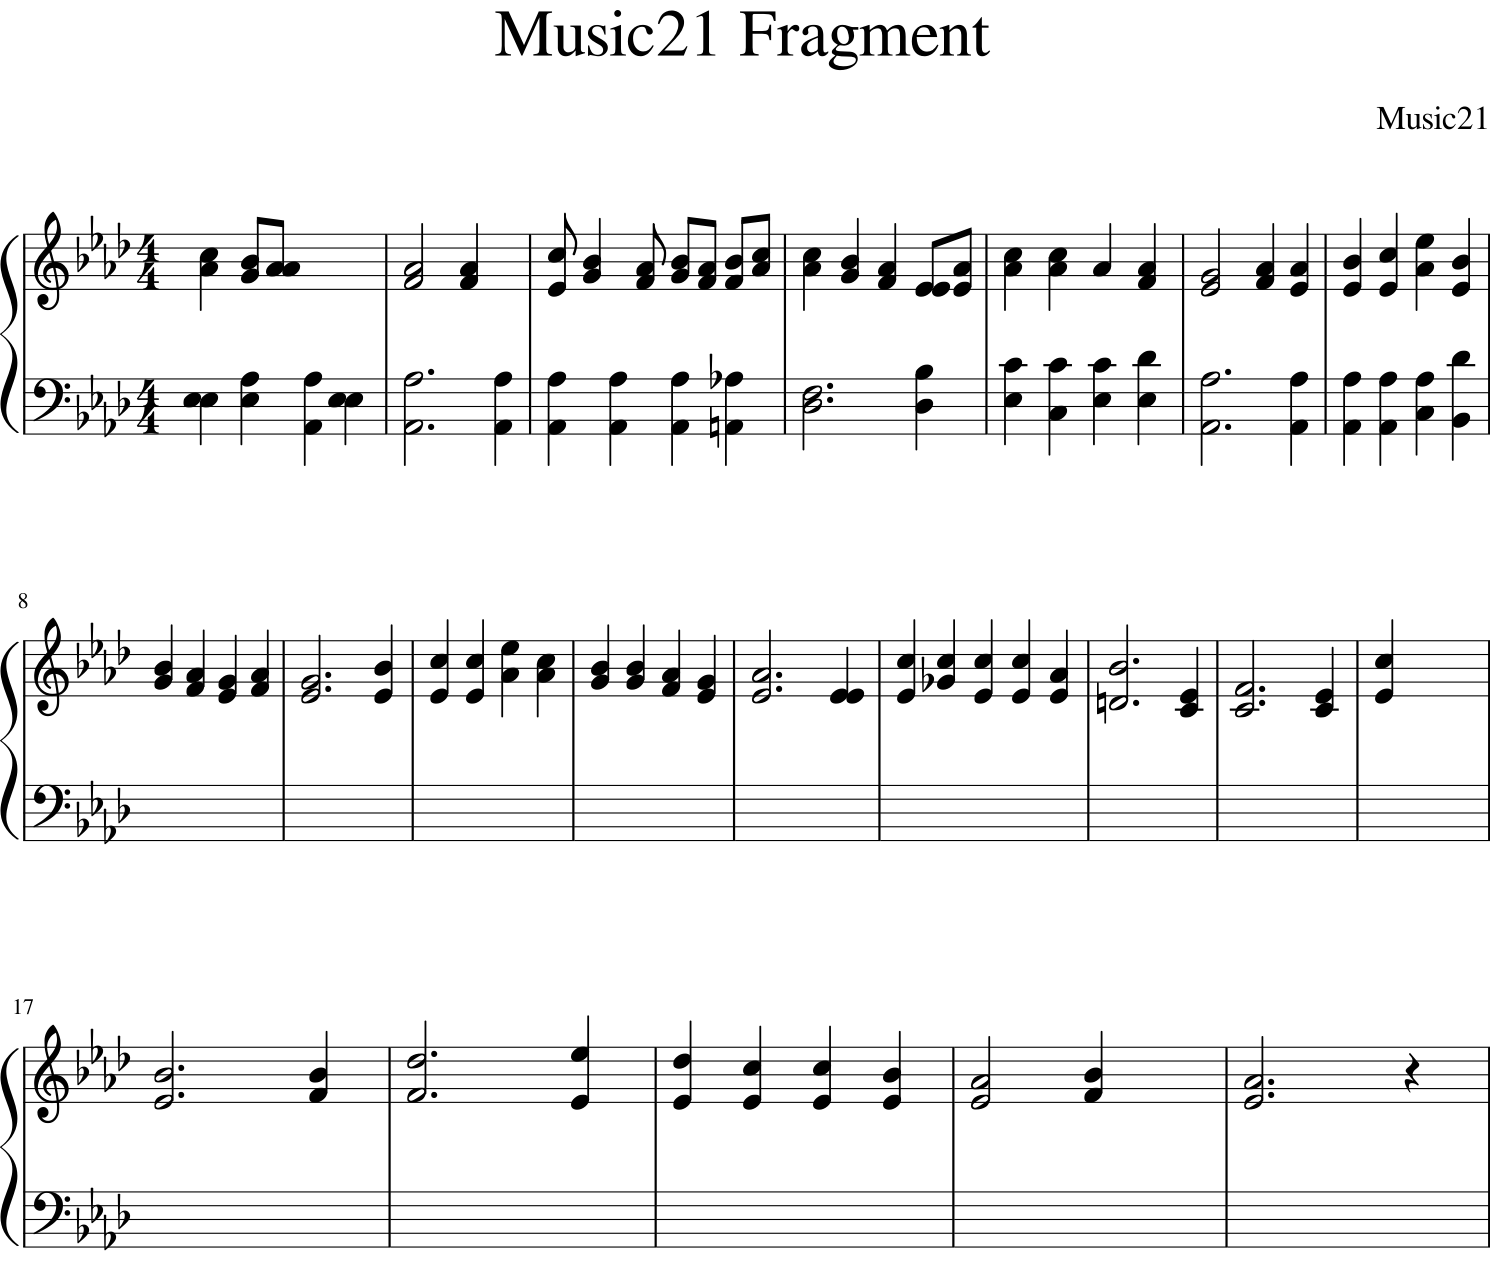

In [10]:
display_and_play("/content/output.musicxml")

# Modele TUTO

#### ============= CREATE SAMPLE DATA FILES -> USE THE REAL ONES!=============

In [27]:
def create_sample_data_files():
    """Create sample pre-tokenized data files for testing"""

    # Create directories
    os.makedirs("data", exist_ok=True)

    # Sample vocabulary (token -> id mapping)
    vocab = {
        "<pad>": 0,
        "<bos>": 1,
        "<eos>": 2,
        "the": 3, "a": 4, "to": 5, "of": 6, "and": 7,
        "in": 8, "is": 9, "it": 10, "for": 11, "on": 12,
        "with": 13, "was": 14, "as": 15, "at": 16, "by": 17,
        "from": 18, "up": 19, "out": 20, "had": 21, "but": 22,
    }

    # Extend vocab to 100 tokens for demo
    for i in range(23, 100):
        vocab[f"token_{i}"] = i

    # Save vocabulary
    with open("data/vocab.json", "w") as f:
        json.dump(vocab, f, indent=2)

    # Generate random pre-tokenized sequences
    # Each sequence: [BOS, random tokens, EOS]
    np.random.seed(42)  # For reproducibility

    def generate_sequences(num_sequences, min_len=5, max_len=20):
        sequences = []
        for _ in range(num_sequences):
            seq_len = np.random.randint(min_len, max_len)
            # Random token IDs between 3-99 (avoiding special tokens 0,1,2)
            tokens = np.random.randint(3, 100, size=seq_len).tolist()
            # Add BOS at start and EOS at end
            sequence = [1] + tokens + [2]
            sequences.append(sequence)
        return sequences

    # Generate train, validation, test sequences
    train_sequences = generate_sequences(100)  # 100 sequences for training
    valid_sequences = generate_sequences(20)   # 20 for validation
    test_sequences = generate_sequences(20)    # 20 for testing

    # Save to files (one sequence per line, space-separated integers)
    def save_sequences(sequences, filepath):
        with open(filepath, "w") as f:
            for seq in sequences:
                f.write(" ".join(map(str, seq)) + "\n")

    save_sequences(train_sequences, "data/train_ids.txt")
    save_sequences(valid_sequences, "data/valid_ids.txt")
    save_sequences(test_sequences, "data/test_ids.txt")

    print("✅ Created sample data files:")
    print("  - data/vocab.json (100 tokens)")
    print("  - data/train_ids.txt (100 sequences)")
    print("  - data/valid_ids.txt (20 sequences)")
    print("  - data/test_ids.txt (20 sequences)")

    return len(vocab)

# Create the sample files
VOCAB_SIZE = create_sample_data_files()

✅ Created sample data files:
  - data/vocab.json (100 tokens)
  - data/train_ids.txt (100 sequences)
  - data/valid_ids.txt (20 sequences)
  - data/test_ids.txt (20 sequences)


#### ============= LOAD DATA FROM FILES =============

In [ ]:
def load_sequences_from_file(filepath):
    """Load pre-tokenized sequences from a file"""
    sequences = []
    with open(filepath, 'r') as f:
        for line in f:
            # Each line contains space-separated integers
            seq = [int(x) for x in line.strip().split()]
            sequences.append(seq)
    return sequences

# Load vocabulary info
# à ne pas mettre car deja fait
'''
with open('data/vocab.json', 'r') as f:
    vocab = json.load(f)
    VOCAB_SIZE = len(vocab)
    BOS_TOKEN_ID = vocab.get('<bos>', 1)
    EOS_TOKEN_ID = vocab.get('<eos>', 2)
    PAD_TOKEN_ID = vocab.get('<pad>', 0)

print(f"\n📊 Vocabulary size: {VOCAB_SIZE}")

print(f"Special tokens - BOS: {BOS_TOKEN_ID}, EOS: {EOS_TOKEN_ID}, PAD: {PAD_TOKEN_ID}")
'''

# Load pre-tokenized sequences
train_sequences = load_sequences_from_file('data/train_ids.txt')
valid_sequences = load_sequences_from_file('data/valid_ids.txt')
test_sequences = load_sequences_from_file('data/test_ids.txt')

print(f"\n📚 Loaded sequences:")
print(f"  Training: {len(train_sequences)} sequences")
print(f"  Validation: {len(valid_sequences)} sequences")
print(f"  Test: {len(test_sequences)} sequences")

# Show example sequence
print(f"\nExample sequence (first training sequence):")
print(f"  Token IDs: {train_sequences[0][:10]}..." if len(train_sequences[0]) > 10 else f"  Token IDs: {train_sequences[0]}")

#### ============= DATASET CLASS =============

In [ ]:
class PostTokenizedDataset(Dataset):
    """Dataset for pre-tokenized integer sequences"""

    def __init__(self, sequences, block_size=128):
        """
        Args:
            sequences: List of lists, each inner list is a sequence of token IDs
            block_size: Maximum sequence length (will chunk longer sequences)
        """
        self.block_size = block_size
        self.examples = []

        # Concatenate all sequences (they already have EOS tokens)
        all_tokens = []
        for seq in sequences:
            all_tokens.extend(seq)

        # Chunk into fixed-size blocks for language modeling
        # This is standard for GPT-2 training
        for i in range(0, len(all_tokens) - block_size + 1, block_size):
            chunk = all_tokens[i:i + block_size]
            if len(chunk) == block_size:  # Only keep full blocks
                self.examples.append(chunk)

        print(f"  Created {len(self.examples)} chunks of size {block_size} from {len(sequences)} sequences")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        """
        For language modeling, we return the same sequence as both input and label.
        HuggingFace's GPT2LMHeadModel internally shifts the labels to predict next tokens.

        Internally, the model does:
        - Input: [A, B, C, D]
        - Predicts: [B, C, D, E]
        - Loss computed on positions 1 to n (ignores position 0 of labels)
        """
        return {
            "input_ids": torch.tensor(self.examples[idx], dtype=torch.long),
            "labels": torch.tensor(self.examples[idx], dtype=torch.long)
        }

#### ============= DATA COLLATOR =============

In [ ]:

class SimpleDataCollator:
    """Simple collator for batching post-tokenized sequences"""
#     Dataset outputs individual examples:
# [1, 23, 45, 67, 89, 12, 34, 56]  # Shape: [128]
# [1, 34, 56, 78, 90, 23, 45, 67]  # Shape: [128]
# [1, 67, 89, 12, 34, 56, 78, 90]  # Shape: [128]
# [1, 45, 67, 89, 12, 34, 56, 78]  # Shape: [128]

# ↓ Collator stacks them ↓

# Batch tensor for GPU/model:
# [[1, 23, 45, 67, 89, 12, 34, 56],
#  [1, 34, 56, 78, 90, 23, 45, 67],
#  [1, 67, 89, 12, 34, 56, 78, 90],
#  [1, 45, 67, 89, 12, 34, 56, 78]]  # Shape: [4, 128]
    def __call__(self, examples):
        # Stack all input_ids and labels
        input_ids = torch.stack([ex["input_ids"] for ex in examples])
        labels = torch.stack([ex["labels"] for ex in examples])

        return {
            "input_ids": input_ids,
            "labels": labels,
        }

#### ============= CONFIGURATION =============

In [ ]:
MAX_LENGTH = 128  # Maximum sequence length for both model and data

print("\n🤖 Configuring model...")

# Small GPT-2 config for testing
config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_positions=MAX_LENGTH,  # Maximum position embeddings
    n_ctx=MAX_LENGTH,        # Context size (same as n_positions)
    n_embd=128,              # Hidden size (very small for testing)
    n_layer=2,               # Number of layers (very small for testing)
    n_head=2,                # Number of attention heads
    bos_token_id=BOS_TOKEN_ID,
    eos_token_id=EOS_TOKEN_ID,
    pad_token_id=PAD_TOKEN_ID,
)

# Initialize model from scratch
model = GPT2LMHeadModel(config)
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"Max sequence length: {MAX_LENGTH} tokens")

#### ============= PREPARE DATASETS =============

In [ ]:

BLOCK_SIZE = MAX_LENGTH  # Use same size for data chunks!

print(f"\n📦 Preparing datasets with block size {BLOCK_SIZE}...")
train_dataset = PostTokenizedDataset(train_sequences, block_size=BLOCK_SIZE)
valid_dataset = PostTokenizedDataset(valid_sequences, block_size=BLOCK_SIZE)
test_dataset = PostTokenizedDataset(test_sequences, block_size=BLOCK_SIZE)

#### ============= TRAINING ARGUMENTS =============

In [ ]:
training_args = TrainingArguments(
    output_dir="./gpt2-pretokenized",
    overwrite_output_dir=True,

    # Training hyperparameters
    num_train_epochs=20,              # Few epochs for testing
    per_device_train_batch_size=4,   # Small batch for testing
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,

    # Learning rate schedule
    learning_rate=5e-4,
    warmup_steps=10,
    weight_decay=0.01,

    # Evaluation and saving - using correct v4.55 syntax
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,

    # Logging
    logging_dir="./logs",
    logging_steps=10,

    # Performance
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
    dataloader_num_workers=0,

    # Disable unwanted features
    push_to_hub=False,
    report_to="none",
)

#### ============= TRAIN MODEL =============

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=SimpleDataCollator(),
)

trainer.train()

In [ ]:
# ============= EVALUATE ON VALIDATION =============
print("\n Evaluating on validation set...")
eval_results = trainer.evaluate()
print(f"Validation loss: {eval_results['eval_loss']:.4f}")

# Calculate perplexity
import math
perplexity = math.exp(eval_results['eval_loss']) if eval_results['eval_loss'] < 20 else float("inf")
print(f"Validation perplexity: {perplexity:.2f}")

# ============= EVALUATE ON TEST =============
print("\n Evaluating on test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test loss: {test_results['eval_loss']:.4f}")

test_perplexity = math.exp(test_results['eval_loss']) if test_results['eval_loss'] < 20 else float("inf")
print(f"Test perplexity: {test_perplexity:.2f}")

In [ ]:


# ============= SAVE MODEL =============
trainer.save_model("./final_model")
print("\n💾 Model saved to ./final_model")


# ============= SIMPLE GENERATION TEST =============
device = next(model.parameters()).device
print(f"Model is on device: {device}")

model.eval()
with torch.no_grad():
    # Start with BOS token
    input_ids = torch.tensor([[BOS_TOKEN_ID]], dtype=torch.long).to(device)

    # Generate 15 tokens
    max_length = 15
    for _ in range(max_length):
        outputs = model(input_ids)
        next_token_logits = outputs.logits[0, -1, :]

        # Sample from top-k tokens for more interesting generation
        top_k = 5
        top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_token = top_k_indices[torch.multinomial(probs, 1)].item()

        # Stop if EOS token
        if next_token == EOS_TOKEN_ID:
            break

        # Create new token on same device
        new_token = torch.tensor([[next_token]], dtype=torch.long).to(device)
        input_ids = torch.cat([input_ids, new_token], dim=1)

    generated = input_ids[0].cpu().tolist()
    print(f"Generated token IDs: {generated}")
    print(f"Length: {len(generated)} tokens")